In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
pd.options.mode.chained_assignment = None  # default='warn'

In [34]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Configurations

In [5]:
rd = 5
start_week = Week(2021,18)
end_week = Week(2021,43)
max_date = datetime.datetime(2021, 6, 23)
models = ["Ensemble","Ensemble_LOP","IHME-IHME_COVID_model_deaths_unscaled","JHUAPL-Bucky","JHU_IDD-CovidSP","Karlen-pypm",
          "MOBS_NEU-GLEAM_COVID","UNCC-hierbin","USC-SIkJalpha","UVA-adaptive"]
# model = "Ensemble"
model = "MOBS_NEU-GLEAM_COVID"

In [2]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = datetime.datetime(2022, 3, 15) #variant
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]
model = models[1]

In [4]:
# rd = 14
# start_week = Week(2022,23)
# end_week = Week(2023,22)
# max_date = None
# models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","MOBS_NEU-GLEAM_COVID_OT","NCSU-COVSIM",
#           "UNCC-hierbin","USC-SIkJalpha","USC-SIkJalpha-update","UTA-ImmunoSEIRS","UVA-adaptive"]
# model = "MOBS_NEU-GLEAM_COVID"
# # model = "Ensemble"

In [3]:
# target = 'death'
target = 'hosp'
incidence = True
target_location = 'US'

locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
location_mapping = dict()
for loc in locations['location']:
    location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

## Load and format surveillance data

In [4]:
if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                (observations['date'] <= pd.to_datetime(end_week.enddate()))]

#filter location
observations = observations[observations['location'] == target_location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

if max_date:
    observations = observations[observations['date'] <= max_date].copy()

#transform to Observation object
observations = Observations(observations)

## Load and filter a single model

In [5]:
target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" 
                          for i in range(1,len(observations)+1)]

In [6]:
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
predictions = predictions.merge(locations, how='inner', on='location')

In [7]:

#choose location
pred = predictions[predictions['location'] == target_location].copy()   

#filter target
pred = pred[(pred['target'].isin(target_prediction_list))]

#filter max date
if max_date:
    pred = pred[pred['target_end_date'] <= max_date]
    
if len(pred) == 0:
    raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

Split by scenarios

In [8]:
scenarios = list(pred['scenario_id'].drop_duplicates())
predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
med_ensemble_predictions = median_ensemble(predictions_list)
ex_ensemble_predictions = extreme_ensemble(predictions_list)
predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme aggregate"]
# print(labels)

## Plot

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
#intervals to show
intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [43]:
fontsize=14
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}\usepackage{sfmath}')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('axes', labelsize=fontsize)
color = '#17B1BF'

/var/folders/tc/9lbjwrhx1dv0_0vb1_v_4q6r0000gp/T/ipykernel_56495/3147635919.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


### Scenarios

In [46]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [47]:
target_loc_name = location_mapping[target_location]

<Figure size 640x480 with 0 Axes>

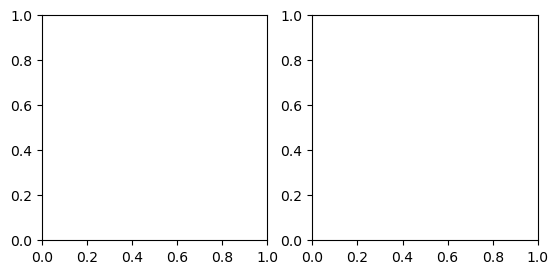

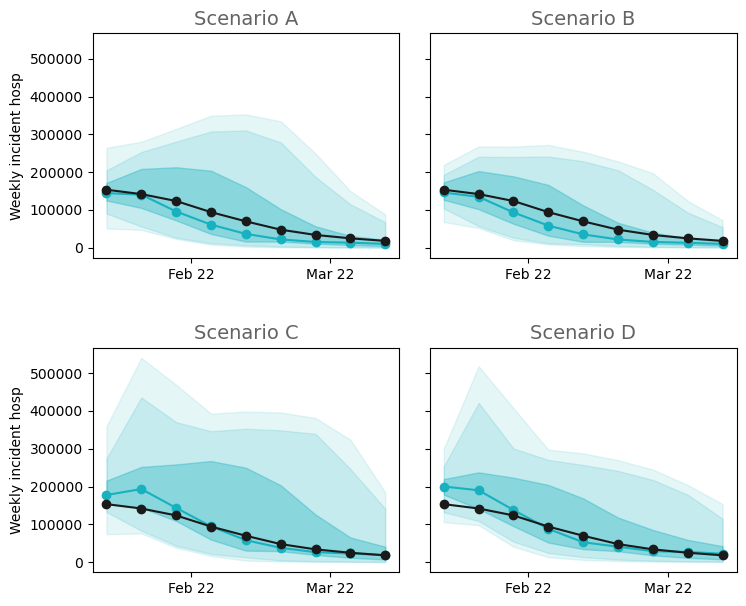

In [71]:
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] 



width = 7
height = 7
fig, axes = plt.subplots(2,2, figsize=(width, height), sharey=True)
plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.85, wspace=0.1,
                    hspace=0.4)
#fig.suptitle(f"{model}, Round {rd}, target = {target_obs}, location = {target_loc_name}", fontsize=fontsize+4)
inds = [[0,0], [0,1], [1,0], [1,1]]
for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
    
    #i = ind // 3
    #j = ind % 3
    
    i = inds[ind][0]
    j = inds[ind][1]
    
    #title
    axes[i][j].set_title(f"{label}", fontsize=fontsize, color='#636363')

    t = np.unique(predictions.get_t())

    #intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes[i][j].fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                               label=fr"PI {int(round(interval_range*100))} %")
    #if i == 0 and j == 0:
    #    axes[i][j].legend(frameon=True, fontsize=fontsize)

    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes[i][j].plot(t,pred_point,'-o',color=color)
    
    #plot surveillance
    axes[i][j].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')
    
    #set x axis
    set_date_axis_fmt(axes[i][j])
    

    #set y axis 
    axes[i][0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
    
    
    
    
    
    
plt.show()  
path = f"./figs/rd{rd}/{'inc' if incidence else 'cum'}_{target}/{target_loc_name}/"
Path(path).mkdir(parents=True, exist_ok=True)

plt.savefig(path+f"{model}.pdf")

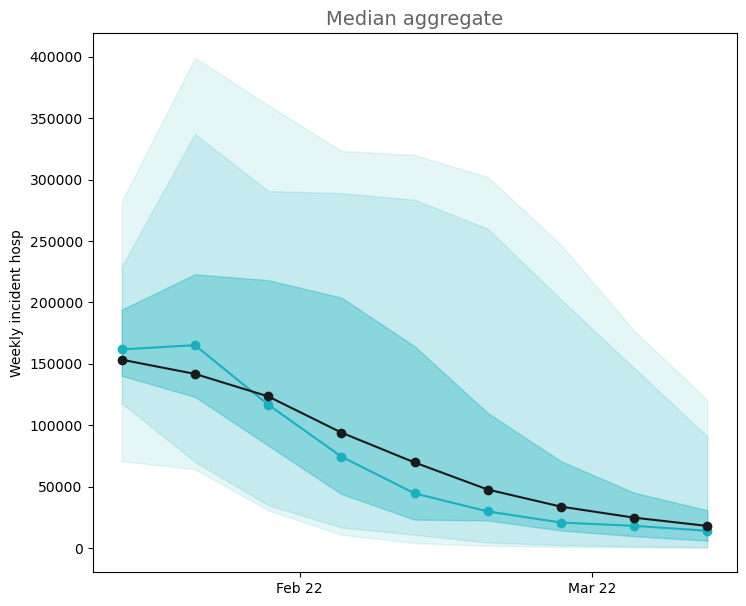

In [67]:
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ['Median aggregate']



width = 7
height = 7
fig1, axes = plt.subplots(1,1, figsize=(width, height), sharey=True)
plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.85, wspace=0.1,
                    hspace=0.4)
#fig.suptitle(f"{model}, Round {rd}, target = {target_obs}, location = {target_loc_name}", fontsize=fontsize+4)
inds = [[0,0], [0,1], [1,0], [1,1]]
for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
    
    if label == 'Median aggregate':
        #i = ind // 3
        #j = ind % 3

        i = 0
        j = 0

        #title
        axes.set_title(f"{label}", fontsize=fontsize, color='#636363')

        t = np.unique(predictions.get_t())

        #intervals
        for interval in intervals:
            q_low,q_upp = interval
            interval_range = q_upp - q_low
            alpha = map_alpha(interval_range)
            pred_low = predictions.get_quantile(q_low)
            pred_upp = predictions.get_quantile(q_upp)
            axes.fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                                   label=fr"PI {int(round(interval_range*100))} %")
        #if i == 0 and j == 0:
        #    axes[i][j].legend(frameon=True, fontsize=fontsize)

        #point estimate
        pred_point = predictions.get_point()
        if len(pred_point) > 0:
            axes.plot(t,pred_point,'-o',color=color)

        #plot surveillance
        axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')

        #set x axis
        set_date_axis_fmt(axes)


        #set y axis 
        axes.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")

        plt.show()  

    
    
    
#plt.show()  

In [77]:
from matplotlib.gridspec import GridSpec

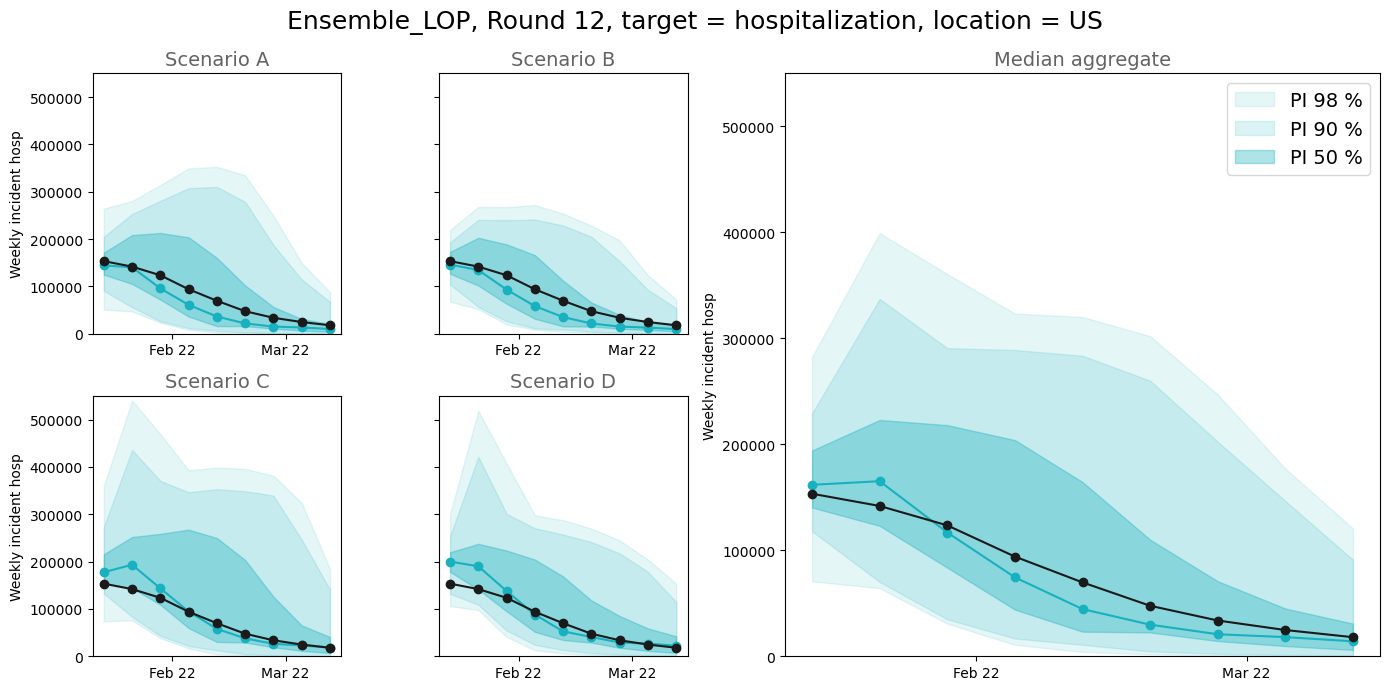

In [103]:
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ['Median aggregate']


# Setting up the plot surface
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(nrows=2, ncols=4)
# First axes

inds = [[0,0], [0,1], [1,0], [1,1], [2,2]]
for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
    
    #i = ind // 3
    #j = ind % 3
    if label == 'Median aggregate':
        ax0 = fig.add_subplot(gs[:, 2:])
        
        #title
        ax0.set_title(f"{label}", fontsize=fontsize, color='#636363')

        t = np.unique(predictions.get_t())

        #intervals
        for interval in intervals:
            q_low,q_upp = interval
            interval_range = q_upp - q_low
            alpha = map_alpha(interval_range)
            pred_low = predictions.get_quantile(q_low)
            pred_upp = predictions.get_quantile(q_upp)
            ax0.fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                                   label=fr"PI {int(round(interval_range*100))} %")
        #if i == 0 and j == 0:
        #    axes[i][j].legend(frameon=True, fontsize=fontsize)

        #point estimate
        pred_point = predictions.get_point()
        if len(pred_point) > 0:
            ax0.plot(t,pred_point,'-o',color=color)

        #plot surveillance
        ax0.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')

        #set x axis
        set_date_axis_fmt(ax0)

        ax0.legend(frameon=True, fontsize=fontsize)

        #set y axis 
        ax0.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
        ax0.set_ylim([0,550000])
    else:
        i = inds[ind][0]
        j = inds[ind][1]

        ax0 = fig.add_subplot(gs[i, j])

        #title
        ax0.set_title(f"{label}", fontsize=fontsize, color='#636363')

        t = np.unique(predictions.get_t())

        #intervals
        for interval in intervals:
            q_low,q_upp = interval
            interval_range = q_upp - q_low
            alpha = map_alpha(interval_range)
            pred_low = predictions.get_quantile(q_low)
            pred_upp = predictions.get_quantile(q_upp)
            ax0.fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                                   label=fr"PI {int(round(interval_range*100))} %")
        #if i == 0 and j == 0:
        #    axes[i][j].legend(frameon=True, fontsize=fontsize)

        #point estimate
        pred_point = predictions.get_point()
        if len(pred_point) > 0:
            ax0.plot(t,pred_point,'-o',color=color)

        #plot surveillance
        ax0.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')

        #set x axis
        set_date_axis_fmt(ax0)


        #set y axis 
        if j == 0:
            ax0.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
        else:
            ax0.set(yticklabels=[])
        ax0.set_ylim([0,550000])


fig.suptitle(f"{model}, Round {rd}, target = {target_obs}, location = {target_loc_name}", fontsize=fontsize+4) 



plt.tight_layout()
plt.savefig("creatingensemblescenarios_loprd12_419.pdf")
plt.show()




## Calculate scores

In [15]:
from collections import defaultdict

In [16]:
timestamped_scores = dict()
aggregated_scores = dict()
for label,predictions in zip(labels,predictions_list):
    d,df = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
    timestamped_scores[label] = df
    aggregated_scores[label] = d

In [17]:
aggregated_data = defaultdict(list)
for label in labels:
    aggregated_data['Case'] += [label]
    aggregated_data['95% PI Coverage'] += [aggregated_scores[label]['95_cov']]
    aggregated_data['50% PI Coverage'] += [aggregated_scores[label]['50_cov']]
    aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
    aggregated_data['MAE'] += [aggregated_scores[label]['point_absolute_error_mean']]
    aggregated_data['WIS dispersion %'] += [100*aggregated_scores[label]['dispersion_wis_fraction']]
    aggregated_data['WIS underprediction %'] += [100*aggregated_scores[label]['underprediction_wis_fraction']]
    aggregated_data['WIS overprediction %'] += [100*aggregated_scores[label]['overprediction_wis_fraction']]

In [18]:
agg_data_df = pd.DataFrame(aggregated_data)
agg_data_df['Model'] = model
agg_data_df

,Case,95% PI Coverage,50% PI Coverage,WIS,MAE,WIS dispersion %,WIS underprediction %,WIS overprediction %,Model
0,Scenario A,1.0,1.0,2152.114711,718.751068,97.058068,0.294430,2.647502,MOBS_NEU-GLEAM_COVID
1,Scenario B,1.0,1.0,2172.567308,862.465337,97.496742,1.510408,0.992849,MOBS_NEU-GLEAM_COVID
2,Scenario C,1.0,1.0,2248.896963,1127.340842,97.171808,2.707774,0.120418,MOBS_NEU-GLEAM_COVID
3,Scenario D,1.0,1.0,2328.299689,1066.140455,97.159455,2.677552,0.162993,MOBS_NEU-GLEAM_COVID
4,Median aggregate,1.0,1.0,2209.961474,906.030399,97.707351,1.822912,0.469737,MOBS_NEU-GLEAM_COVID
5,Extreme aggregate,1.0,1.0,2554.585255,906.030399,98.457964,1.166247,0.375789,MOBS_NEU-GLEAM_COVID
